In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import time
from tqdm import tqdm
from typing import List
from typing import Union

from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import TriplesFactory
import torch

/home/jovyan/.conda/envs/bioblp-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
from nb_utils.eval_utils import TEST, VALID, TRAIN, TEST_EXCLUDING_DIS, TEST_RESTRICTED_DIS
from nb_utils.eval_utils import COL_SOURCE, COL_TARGET, COL_EDGE, COL_NODE, DEGREE, IN_DEGREE, OUT_DEGREE
from nb_utils.eval_utils import obtain_filtered_triples, split_test_triples_conditioned_on_ent_property, split_train_ents_by_existance_of_properties
from nb_utils.eval_utils import setup_wandb_result_tracker, run_experiment_and_log_wandb
from nb_utils.eval_utils import make_results_dict_all_rel, make_results_dict_rel_breakdown
from nb_utils.eval_utils import evaluate_lp_all_rels_on_single_test_set
from nb_utils.eval_utils import evaluate_lp_relwise_on_single_test_set


Change this cell to generate a report for other datasets/models:

In [6]:
SHARED_DATA_DIR = Path("/home/jovyan/workbench-shared-folder/bioblp")
PROJ_DATA_DIR = Path("../data/")

In [7]:
# model registry
ROTATE = "rotate"
BIOBLP_D = "bioblp_d"

MODEL_ID_rotate = 'rotate-otxtubeb' 
MODEL_ID_bioblpd = 'bioblpd-38uz9fjs'

MODELS = {
    ROTATE: MODEL_ID_rotate,
    BIOBLP_D: MODEL_ID_bioblpd
}

In [8]:
model_registry_basedir = SHARED_DATA_DIR.joinpath(f"models")
model_registry_paths = {v: model_registry_basedir.joinpath(f"{v}") for v in MODELS.values()}
model_registry_paths

{'rotate-otxtubeb': PosixPath('/home/jovyan/workbench-shared-folder/bioblp/models/rotate-otxtubeb'),
 'bioblpd-38uz9fjs': PosixPath('/home/jovyan/workbench-shared-folder/bioblp/models/bioblpd-38uz9fjs')}

In [9]:
graph_path = PROJ_DATA_DIR.joinpath('biokgb/graph')
valid_triples = 'biokg.links-valid.csv'
test_triples = 'biokg.links-test.csv'
dummy_triples = 'biokg.links-dummy.csv'

##  Loading model and data

make a keyword based switching statement b/w rotate and bioblp-d

In [10]:
def load_kge_model(model_base_path):
    '''model = load_kge_model(model_base_path = model_registry_paths[MODEL_ID])
    '''
    model_path = model_base_path.joinpath("trained_model.pkl")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load(model_path, map_location=torch.device(device))
    #train = TriplesFactory.from_path_binary(model_base_path.joinpath("training_triples"))
    return model
    

In [11]:
# load rotate, or bioblp-d
MODEL_ID = MODELS.get(ROTATE)    
train = TriplesFactory.from_path_binary(model_registry_paths[MODEL_ID].joinpath("training_triples"))

creating a dummy set of triples for unit testing purposes

In [22]:
DUMMY = 'dummy'
dummy_triples = 'biokg.links-dummy.csv'
if not graph_path.joinpath(dummy_triples).exists:
    print('Slicing test triples to create a batch of dummy triples')
    dummy_df = pd.read_csv(graph_path.joinpath(test_triples), sep="\t", header=None)[:50]
    dummy_df.to_csv(graph_path.joinpath(dummy_triples), sep="\t", index=None, header=None)

In [23]:
valid, test, dummy = [TriplesFactory.from_path(graph_path.joinpath(f),
                                        entity_to_id=train.entity_to_id,
                                        relation_to_id=train.relation_to_id)
               for f in (valid_triples, test_triples, dummy_triples)]

#### Split test triples conditional on whether they contain entities whose properties were encoded in BIOBLP-X vs not

Create test sets: 
D; D_b, D_r; 

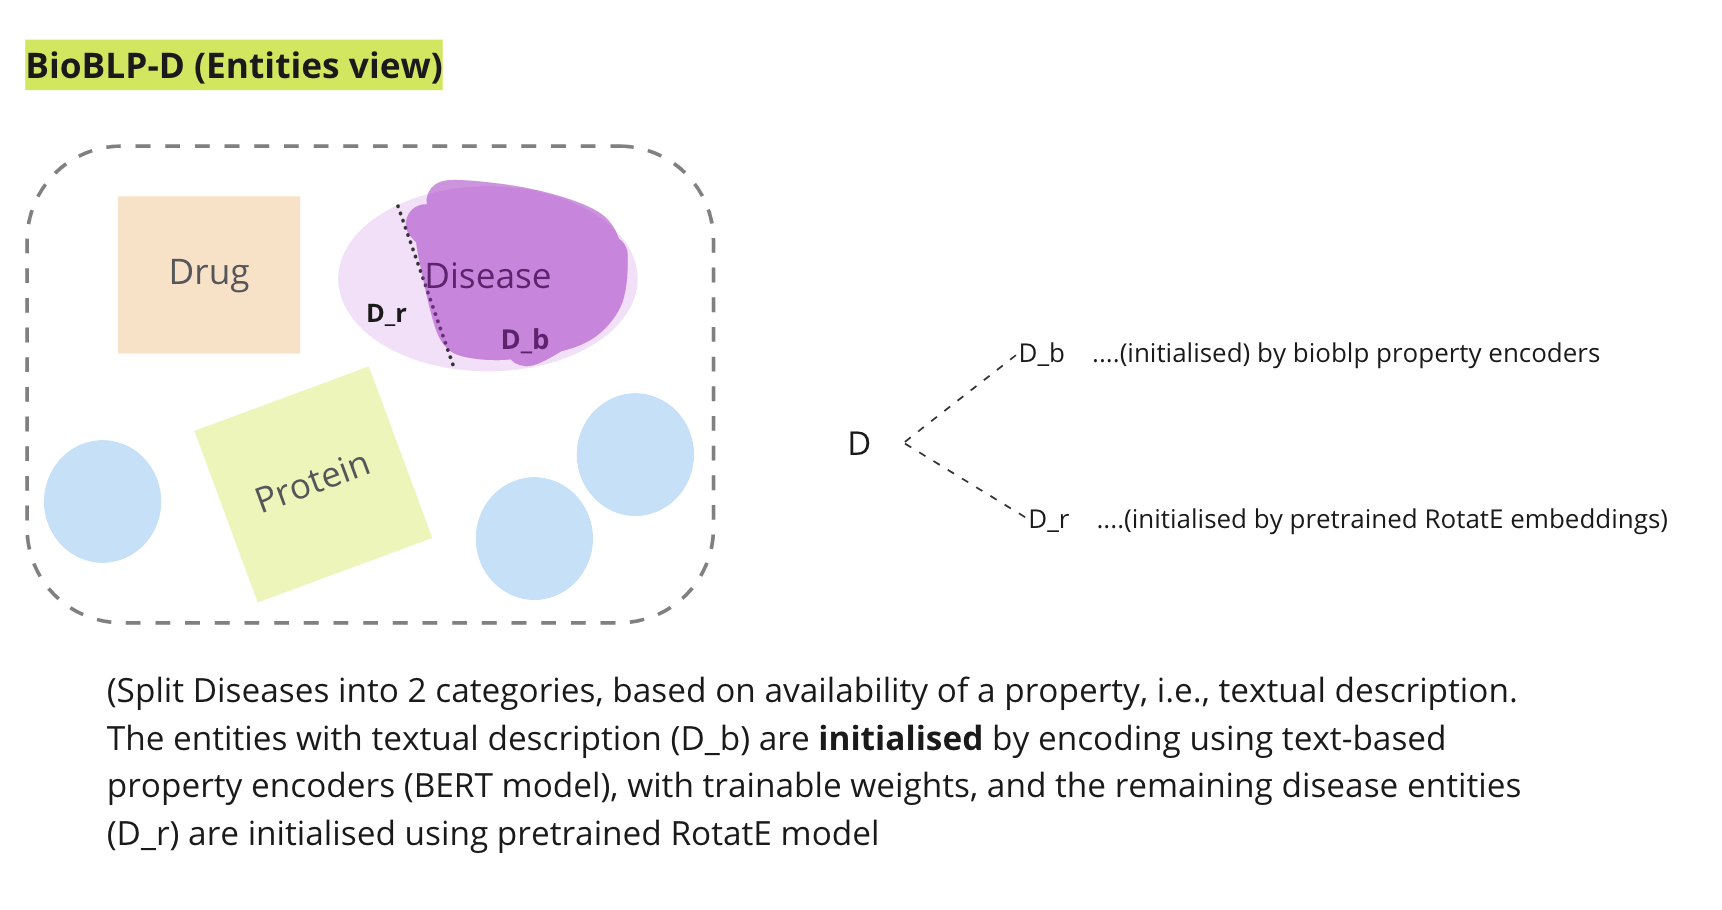

In [15]:
from IPython.display import Image
Image('data/imgs/eval_split_entity_view.png', width=600)

From stats below, we see that all biokgb entities surprisingly have a relation - > D_r is an empty set. -> This is because we used the name of disease as decription in places where it was missing

In [19]:
disease_descr_path = PROJ_DATA_DIR.joinpath("biokgb/properties/biokg_meshid_to_descr_name.tsv")
disease_metadata_path = PROJ_DATA_DIR.joinpath("biokgb/properties/biokg.metadata.disease.tsv")

# create a subset of biokg entities of type Disease 
diseases = pd.read_csv(disease_metadata_path, sep="\t", names=["disease", "rel", "node_type"])
disease_set = set(diseases.disease.values)
print(f"# Disease entities in larger biokg (pre-benchmark removal): {len(disease_set)}")

# create a set of disease entities for which we have text descriptions
disease_w_desc_df = pd.read_csv(disease_descr_path, sep="\t", header=0, names=["disease", "desc"])
disease_desc_set = set(disease_w_desc_df.disease.values)
print(f"# Disease entities in larger biokg (pre-benchmark removal) for which we have textual descriptions: {len(disease_desc_set)}")


# Disease entities in larger biokg (pre-benchmark removal): 11347
# Disease entities in larger biokg (pre-benchmark removal) for which we have textual descriptions: 11347


In [20]:
# Side note: all disease entities in Biokgb have decscriptions; because missing values were plugged with disease names
disease_w_desc_df["len"] = disease_w_desc_df["desc"].str.len()
disease_w_desc_df.len.describe()

count    11347.000000
mean       149.042743
std        156.370558
min          5.000000
25%         37.000000
50%         70.000000
75%        231.000000
max       1076.000000
Name: len, dtype: float64

#### define test sets

The figure below demonstrates how we obtain the various test sets

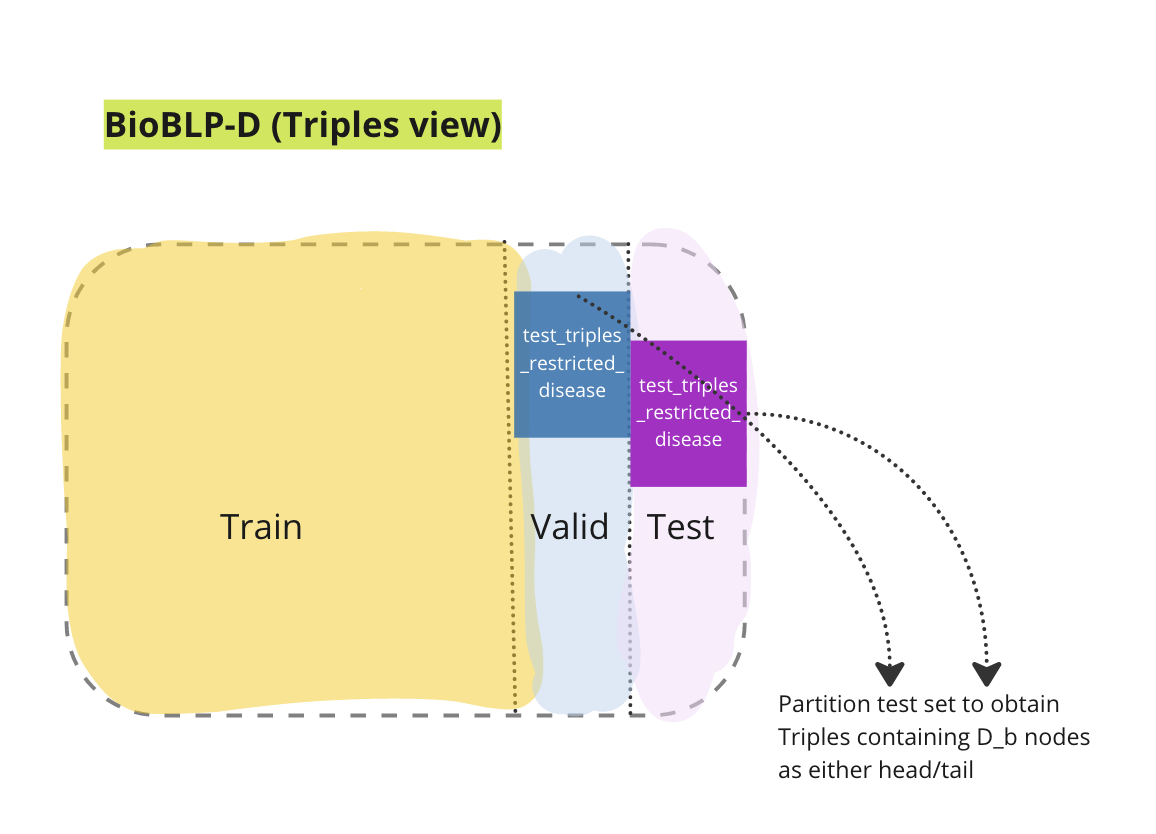

In [56]:
Image('data/imgs/eval_split_triples_view.png', width=500)

In [24]:
test_triples_incl_dis_prop, test_triples_excl_dis_prop = split_test_triples_conditioned_on_ent_property(train_triples=train, 
                                                                                                        typed_ent_set=disease_set, 
                                                                                                        typed_ent_with_prop_set=disease_desc_set,
                                                                                                        test_triples=test)

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [ ]:
# relations containing diseases include -> 
dis_assoc_rels = {rel:rel_id for rel, rel_id in train.relation_to_id.items() if 'DISEASE' in rel}
dis_assoc_rels

In [26]:
# create set of triples
print(f"# triples originally in test: {test.num_triples}, valid: {valid.num_triples}")
print(f"# test triples with disease nodes: {test_triples_incl_dis_prop.num_triples}")
print(f"# test triples without disease nodes: {test_triples_excl_dis_prop.num_triples}")


# triples originally in test: 185227, valid: 185226
# test triples with disease nodes: 17063
# test triples without disease nodes: 168164


In [ ]:
triples_dict = {
    TEST: test,
    VALID: valid,
    TRAIN: train,
    TEST_RESTRICTED_DIS: test_triples_incl_dis_prop,
    TEST_EXCLUDING_DIS: test_triples_excl_dis_prop,
    DUMMY: dummy, 
}

TEST_SET_LIST = [TEST_RESTRICTED_DIS, TEST_EXCLUDING_DIS, TEST, VALID]


# Evaluation

wandb logging

In [39]:
import wandb
wandb.login()

WANDB_ENTITY_DISCOVERYLAB = "discoverylab"
WANDB_PROJECT_NAME = "bioblp-jupyter-trial"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pmitra01 (discoverylab). Use `wandb login --relogin` to force relogin


sanity check logic for experiment run with wandb logging

In [22]:
def trial_func(x=1, y=2):
    print(x*y)
    return {'x': x, 'y':y}

#trial_func_kwargs = {"x": 1, "y": 2} 
#metrics = run_experiment('dummy-run', TEST, BIOBLP_D, trial_func, **trial_func_kwargs) 

### LP performace: Micro averaged metrics across All Relations

In [53]:
def run_wandb_eval_lp_all_rels_on_multiple_test_sets(model_id: str,
                                                  test_set_list: List[str],
                                                  eval_out_dir: Union[Path, str],
                                                  wandb_project_name=WANDB_PROJECT_NAME):
    micro_results_dicts = {}
    STUDY_EVAL_MICRO_AVG = "eval-micro-avg"
    study_name = STUDY_EVAL_MICRO_AVG
        
    timestr = time.strftime("%Y%m%d-%H%M%S")
    eval_out_dir = Path(eval_out_dir).joinpath(timestr)
    eval_out_dir.mkdir(exist_ok=True , parents=True)
    print(f"Metrics will be saved to {str(eval_out_dir)}")

    model = load_kge_model(model_registry_paths.get(model_id))
    train_triples = triples_dict.get(TRAIN)
    valid_triples = triples_dict.get(VALID)
    
    for test_set_slug in test_set_list:
        print(f"Model being evaluated: {model_id}, of type {type(model)}")
        func_kwargs = {
            "model": model, 
            "eval_test_set_slug": test_set_slug, 
            "eval_triples": triples_dict.get(test_set_slug),
            "train_triples": train_triples,
            "valid_triples": valid_triples 
        }

        rel_results = run_experiment_and_log_wandb(study_name=study_name, 
                                                   test_set_slug=test_set_slug, 
                                                   model_name=MODEL_ID, 
                                                   eval_func=evaluate_lp_all_rels_on_single_test_set, 
                                                   wandb_project_name=wandb_project_name,
                                                   **func_kwargs
                                                  )
        micro_results_dicts[test_set_slug] = rel_results

    with open(eval_out_dir.joinpath(f'{study_name}.json'), 'w+') as f:
        json.dump(micro_results_dicts, f)

let's try a test run on a dummy set of triples

In [45]:
# dummy run
dummy_func_kwargs = {"model": model, 
                     "eval_test_set_slug": DUMMY,
                     "eval_triples": triples_dict.get(DUMMY),
                     "train_triples": triples_dict.get(TRAIN),
                     "valid_triples": triples_dict.get(VALID)}
dummy_results = evaluate_lp_all_rels_on_single_test_set(**dummy_func_kwargs)

results_microavg_test_retricted_dis = run_experiment_and_log_wandb(
    study_name='dummy-run-eval', 
    wandb_project_name=WANDB_PROJECT_NAME,
    test_set_slug=TEST_RESTRICTED_DIS, 
    model_name=MODEL_ID, 
    eval_func=evaluate_lp_all_rels_on_single_test_set, 
    **dummy_func_kwargs
)



Evaluating on cpu: 100%|██████████| 50.0/50.0 [00:21<00:00, 2.29triple/s]
Evaluating on cpu: 100%|██████████| 50.0/50.0 [00:22<00:00, 2.26triple/s]


Cool, that seems to succesfully evaluate LP on fummy triples, and log to wandb
If satisfied, move on to actual test sets

In [54]:
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)
DUMMY_TEST_LIST = [DUMMY]
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

run_wandb_eval_lp_all_rels_on_multiple_test_sets(model_id=MODEL_ID,
                                             test_set_list=DUMMY_TEST_LIST,#TEST_SET_LIST,
                                             eval_out_dir=eval_out_dir)

Metrics will be saved to metrics/rotate-otxtubeb/20230316-122607
Model being evaluated: rotate-otxtubeb, of type <class 'pykeen.models.unimodal.rotate.RotatE'>


Evaluating on cpu: 100%|██████████| 50.0/50.0 [00:22<00:00, 2.27triple/s]


Count,▁
adjusted_arithmetic_mean_rank,▁
arithmetic_mean_rank,▁
hits_at_1,▁
hits_at_10,▁
hits_at_3,▁
hits_at_5,▁
inverse_harmonic_mean_rank,▁
Count,50
Relation,All
adjusted_arithmetic_mean_rank,0.02921


In [25]:
MODEL_NAME_SLUG = BIOBLP_D
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

run_wandb_eval_lp_all_rels_on_multiple_test_sets(model_id=MODEL_ID,
                                             test_set_list=TEST_SET_LIST,
                                             eval_out_dir=eval_out_dir)

Evaluating on cuda:0: 100%|██████████| 17.1k/17.1k [02:55<00:00, 97.0triple/s]


Evaluating on cuda:0: 100%|██████████| 168k/168k [29:10<00:00, 96.1triple/s] 


Evaluating on cuda:0: 100%|██████████| 185k/185k [32:09<00:00, 96.0triple/s] 


Evaluating on cuda:0: 100%|██████████| 185k/185k [31:44<00:00, 97.3triple/s] 


## Evaluating over specific. relation types

In [57]:
def run_wandb_eval_lp_relwise_on_multiple_test_sets(model_id: str,
                                                  test_set_list: List[str],
                                                  eval_out_dir: Union[Path, str],
                                                  wandb_project_name=WANDB_PROJECT_NAME):
    relwise_results_dicts = {}
    STUDY_EVAL_REL_BREAKDOWN = "eval-rel-breakdown"
    study_name = STUDY_EVAL_REL_BREAKDOWN
    
    timestr = time.strftime("%Y%m%d-%H%M%S")
    eval_out_dir = Path(eval_out_dir).joinpath(timestr)
    eval_out_dir.mkdir(exist_ok=True , parents=True)
    print(f"Metrics will be saved to {str(eval_out_dir)}")
    
    model = load_kge_model(model_registry_paths.get(model_id))
    train_triples = triples_dict.get(TRAIN)
    valid_triples = triples_dict.get(VALID)
    
    for test_set_slug in test_set_list:
        print(f"Model being evaluated: {model_id}, of type {type(model)}")
        func_kwargs = {"model": model, 
                       "eval_test_set_slug": test_set_slug,
                       "eval_triples": triples_dict.get(test_set_slug),
                       "train_triples": train_triples,
                       "valid_triples": valid_triples 
                      }

        rel_results = run_experiment_and_log_wandb(study_name=study_name, 
                                                   test_set_slug=test_set_slug, 
                                                   model_name=model_id, 
                                                   eval_func=evaluate_lp_relwise_on_single_test_set, 
                                                   wandb_project_name=wandb_project_name,
                                                   **func_kwargs
                                                  )
        relwise_results_dicts[test_set_slug] = rel_results
    with open(eval_out_dir.joinpath(f'{study_name}.json'), 'w+') as f:
        json.dump(relwise_results_dicts, f)


#### test: run on RotatE

In [64]:
# parameterise MODEL_NAME_SLUG as single point of entry into chain of model related parameters
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
DUMMY_TEST_LIST = [DUMMY]
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

run_wandb_eval_lp_relwise_on_multiple_test_sets(model_id=MODEL_ID,
                                             test_set_list=DUMMY_TEST_LIST,
                                             eval_out_dir=eval_out_dir,
                                             wandb_project_name=WANDB_PROJECT_NAME)

Metrics will be saved to metrics/rotate-otxtubeb/20230316-123752
Model being evaluated: rotate-otxtubeb, of type <class 'pykeen.models.unimodal.rotate.RotatE'>


Evaluating over each relation: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]


Count,▁
adjusted_arithmetic_mean_rank,▁
arithmetic_mean_rank,▁
hits_at_1,▁
hits_at_10,▁
hits_at_3,▁
hits_at_5,▁
inverse_harmonic_mean_rank,▁
Count,50
Relation,All
adjusted_arithmetic_mean_rank,0.02921


#### test on all test sets with BIOBLP_D


**Note, RotatE and BioBLP-D pretrained models have been trained with different pykeen versions - I had to downgrade to pykeen 1.8.2 to load the old roatatE. And then again upgrade to latest pykeen (check --v)**

In [63]:
MODEL_NAME_SLUG = BIOBLP_D
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

run_wandb_eval_lp_relwise_on_multiple_test_sets(model_id=MODEL_ID,
                                             test_set_list=TEST_SET_LIST,
                                             eval_out_dir=eval_out_dir,
                                             wandb_project_name=WANDB_PROJECT_NAME)

Metrics will be saved to metrics/bioblpd-38uz9fjs/20230316-123737
Model being evaluated: bioblpd-38uz9fjs, of type <class 'bioblp.models.bioblp.BioBLP'>


Evaluating over each relation:  12%|█▏        | 2/17 [00:00<00:00, 23.64it/s]


AttributeError: 'BioBLP' object has no attribute 'device'

Based on the above, we can create requisite plots as done in https://api.wandb.ai/links/discoverylab/n5150z4m 

In [30]:
LOAD_ROTATE_EVAL_RELWISE_METRICS=True
if LOAD_ROTATE_EVAL_RELWISE_METRICS:
    out_dir = Path(f'metrics/{MODELS.get(ROTATE)}')
    STUDY_EVAL_REL_BREAKDOWN = 'eval-rel-breakdown'

    with open(out_dir.joinpath(f'{STUDY_EVAL_REL_BREAKDOWN}.json'), 'r') as f:
        metrics_relwise_rotate =  json.load(f)

In [28]:
LOAD_BIOBLP_EVAL_RELWISE_METRICS=True
if LOAD_BIOBLP_EVAL_RELWISE_METRICS:
    out_dir = Path(f'metrics/{MODELS.get(BIOBLP_D)}')
    STUDY_EVAL_REL_BREAKDOWN = 'eval-rel-breakdown'

    with open(out_dir.joinpath(f'{STUDY_EVAL_REL_BREAKDOWN}.json'), 'r') as f:
        metrics_relwise_bioblpd =  json.load(f)

### [Optional] custom plots for WandB (plotting 2 data series within same scatter plot)


In [29]:
results_df = pd.DataFrame(metrics_relwise_bioblpd[TEST_RESTRICTED_DIS])
results_df.transpose().reset_index().rename(columns={'index':'Relation'})

,Relation,Count,arithmetic_mean_rank,adjusted_arithmetic_mean_rank,inverse_harmonic_mean_rank,hits_at_1,hits_at_3,hits_at_5,hits_at_10
0,DISEASE_GENETIC_DISORDER,261.0,2200.370605,0.041507,0.632742,0.590038,0.647510,0.683908,0.724138
1,DISEASE_PATHWAY_ASSOCIATION,293.0,3717.679932,0.070119,0.116742,0.078498,0.141638,0.162116,0.180887
2,DRUG_DISEASE_ASSOCIATION,6749.0,1575.149048,0.029739,0.025802,0.009409,0.022300,0.031338,0.052008
3,PROTEIN_DISEASE_ASSOCIATION,9760.0,5188.562500,0.098028,0.064648,0.047490,0.066393,0.078279,0.095236


In [81]:
#### logging custom plots to wandb for rel-wise
#wandb.finish()

In [82]:
model_id = MODEL_ID_rotate

for test_set_slug, result_dicts in metrics_relwise_rotate.items():
    tags = {"model_name": model_id,
                "study_name": 'eval_rel_breakdown_custom_plot',
                "test_set_type": test_set_slug}
    run = setup_wandb_result_tracker(**tags, project_name=WANDB_PROJECT_NAME, wandb_entity=WANDB_ENTITY_DISCOVERYLAB)
    results_df = pd.DataFrame(result_dicts).transpose()
    results_df = results_df.reset_index().rename(columns={'index':'Relation'})

    metric_cols = list(results_df.columns)
    metric_cols=[x for x in metric_cols if x != 'Relation']

    for metric in metric_cols:
        rel_metric_dict = dict(zip(results_df.Relation, results_df[metric]))
        data = [[rel, val] for (rel, val) in rel_metric_dict.items()]
        table = wandb.Table(data=data, columns = ["relation", "value"])
        wandb.log({f"bar_chart_{metric}" : wandb.plot.bar(table, "relation",
                                   "value", title=f"{metric} by relation")})

In [83]:
model_id=MODEL_ID_bioblpd

for test_set_slug, result_dicts in metrics_relwise_bioblpd.items():
    tags = {"model_name": model_id,
                "study_name": 'eval_rel_breakdown_custom_plot',
                "test_set_type": test_set_slug}
    run = setup_wandb_result_tracker(**tags, project_name=WANDB_PROJECT_NAME, wandb_entity=WANDB_ENTITY_DISCOVERYLAB)
    results_df = pd.DataFrame(result_dicts).transpose()
    results_df = results_df.reset_index().rename(columns={'index':'Relation'})

    metric_cols = list(results_df.columns)
    metric_cols=[x for x in metric_cols if x != 'Relation']

    for metric in metric_cols:
        rel_metric_dict = dict(zip(results_df.Relation, results_df[metric]))
        data = [[rel, val] for (rel, val) in rel_metric_dict.items()]
        table = wandb.Table(data=data, columns = ["relation", "value"])
        wandb.log({f"bar_chart_{metric}" : wandb.plot.bar(table, "relation",
                                   "value", title=f"{metric} by relation")})

## archived

### previous stuff

How do MRR, H@k, and AMR correlate?

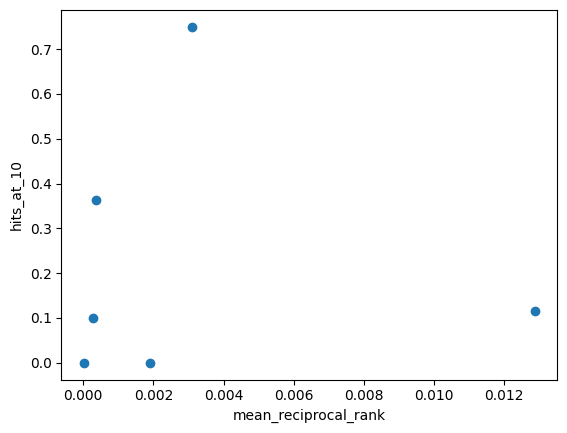

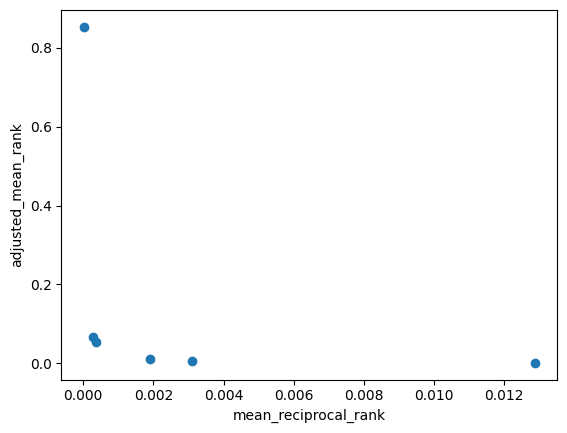

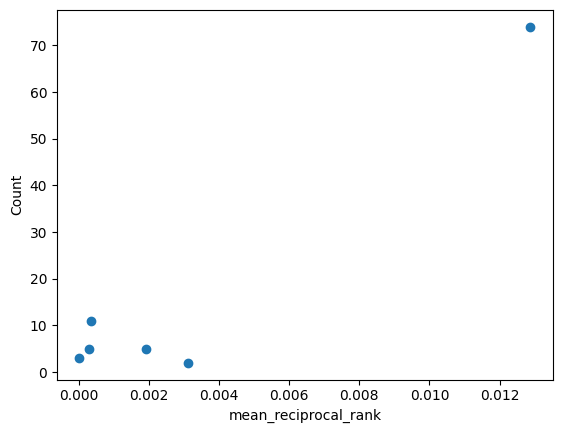

In [32]:
def plot_metric_pair(results_df, metric_1: str, metric_2: str):
    """Make a scatter plot with one link prediction metric in each axis."""
    plt.figure()
    plt.scatter(results_df[metric_1], results_df[metric_2])
    plt.xlabel(metric_1)
    plt.ylabel(metric_2)

plot_metric_pair(results_df, 'mean_reciprocal_rank', 'hits_at_10')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'adjusted_mean_rank')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'Count')